# 🏠 House Price Prediction - Project Overview

## 1. Business Understanding

Predicting house prices is a classic problem in the real estate domain. Accurate price prediction helps:

- Homebuyers understand fair value of a property
- Property developers set competitive pricing
- Real estate investors identify undervalued assets

In this project, we aim to **build a machine learning model** that can predict the **final sale price** of residential homes in Ames, Iowa, using features such as lot size, number of rooms, year built, and more.

## 2. Objective

The main objective of this project is to:

> 🎯 **Predict the `SalePrice` of a house based on multiple features provided in the dataset.**

We will follow a structured machine learning pipeline:
1. Exploratory Data Analysis (EDA)
2. Data Preprocessing
3. Feature Engineering
4. Model Training & Evaluation
5. Final Prediction & Result Analysis

By the end of this notebook, we expect to have a regression model with good generalization ability, ready to be submitted on Kaggle or used in a real-world scenario.

---
## 🔄 Machine Learning Pipeline Overview

The following flowchart summarizes the entire process used in this notebook — from loading the dataset, cleaning the data, training the model, and finally making predictions.

It offers a quick visual guide to help readers understand how the pieces fit together in our house price prediction project.

```
[Start]
   |
   v
[Load Dataset (train.csv)]
   |
   v
[Missing Values Analysis]
   |
   v
[Categorical Feature Exploration]
   |
   v
[Preprocessing]
   ├─ Fill missing values
   ├─ Apply ordinal mapping
   └─ One-hot encode nominal features
   |
   v
[Correlation Analysis]
   ├─ Identify strongly correlated features
   └─ Decide on feature inclusion strategy
   |
   v
[Train-Test Split]
   |
   v
[Train Linear Regression Model]
   |
   v
[Evaluate Model]
   ├─ RMSE
   ├─ R² Score
   └─ Prediction vs Actual comparison
   |
   v
[Interpretation & Insights]
   |
   v
[Future Implementation Plan (Optional Appraisal Tool)]
   |
   v
[End]

```

Let's begin!

# 🔍 Exploratory Data Analysis (EDA)

## 1. Load Dataset & Initial Inspection

We will start by loading the dataset and performing a quick inspection to understand:

- The size of the dataset
- The column names and data types
- Presence of missing values or duplicates
- A quick look at the first few rows

This step is important to get familiar with the structure of the data before diving deeper.


In [1]:
import pandas as pd

# Load the training dataset
df = pd.read_csv("train.csv")  # Make sure the train.csv file is in the same directory as this notebook

# Print the shape of the dataset (rows, columns)
print(f"Dataset shape: {df.shape}")

# Display the first 5 rows of the dataset
df.head()

Dataset shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2. Data Types & Missing Values

Let’s inspect column types and check for missing data.

This will help us prepare for data cleaning and feature engineering in the next step.


In [2]:
# Check the distribution of data types
df.dtypes.value_counts()


object     43
int64      35
float64     3
Name: count, dtype: int64

In [3]:
# Check for missing values in each column
missing_values = df.isnull().sum()

# Filter only columns with missing values
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Display missing value count as a DataFrame
missing_values.to_frame(name='Missing Count')


,Missing Count
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageType,81
GarageYrBlt,81
GarageFinish,81


## 3. Missing Values Analysis

Some columns have a significant amount of missing values, which may indicate the absence of a particular feature (e.g., no pool, no alley access, no fireplace).

We can categorize missing data as follows:

- **Too many missing values:** (`PoolQC`, `MiscFeature`, `Alley`, `Fence`) - may be dropped or filled with 'None'.
- **Feature not applicable:** (`Garage*`, `Bsmt*`, `FireplaceQu`) - likely missing because the house lacks the feature.
- **Numeric values:** (`LotFrontage`, `MasVnrArea`) - may be imputed using statistical strategies (mean, median, or grouped).
- **Low missingness:** (`Electrical`) - can be filled with the most common value.

We will handle missing values accordingly in the preprocessing step.


### 🧠 Handling Missing Values - Based on Percentage and Context

When deciding how to treat missing values, it's important to consider both the **percentage of missing data** and the **contextual meaning** of each feature. Here's a practical guideline:

#### 📊 General Rule of Thumb:
- **< 5% missing** → Impute using mean, median, or mode.
- **5%–20% missing** → Still usable; impute or analyze further.
- **20%–50% missing** → Be cautious. Retain only if the feature adds significant value.
- **> 50% missing** → Often dropped, unless the feature is contextually important.

#### 🔍 But context matters:

In this dataset, many features are missing not because of data errors, but because the feature **doesn't exist** in those houses. For example:
- `PoolQC`: Most houses don't have pools → fill with `'None'`
- `Alley`: Many homes don’t have alley access → fill with `'None'`
- `FireplaceQu`: Missing implies no fireplace → fill with `'None'`

Therefore, dropping them outright may result in losing valuable absence indicators.

#### ✅ Our Strategy:
- **Drop features** only if they have extremely high missingness **and low importance**
- **Impute with `'None'`** if missingness represents **absence of a feature**
- **Use statistical imputation** (median, mode) for essential numeric features

This approach allows us to retain potentially valuable information without introducing noise or bias.


## 4. SalePrice Distribution

Let’s start by examining the distribution of the target variable `SalePrice`. 

This helps us understand:

- Whether the data is normally distributed
- Presence of outliers
- Whether transformation (e.g., log) is needed


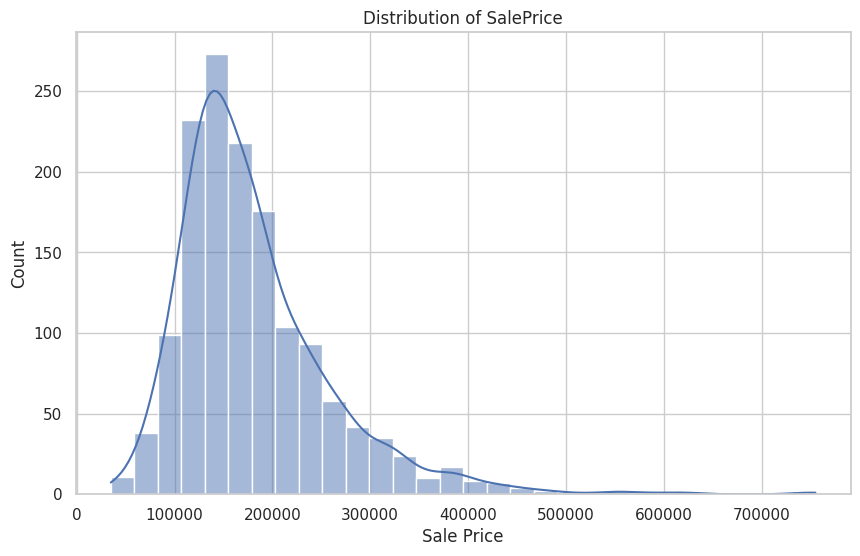

Skewness: 1.88
Kurtosis: 6.54


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual style
sns.set(style="whitegrid")

# Plot SalePrice distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['SalePrice'], kde=True, bins=30)
plt.title("Distribution of SalePrice")
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.show()

# Skewness and kurtosis
print(f"Skewness: {df['SalePrice'].skew():.2f}")
print(f"Kurtosis: {df['SalePrice'].kurt():.2f}")


**Interpretation:**

The distribution of `SalePrice` is right-skewed, as indicated by the **skewness value of 1.88**. This suggests that most houses are moderately priced, with a few very expensive ones pulling the distribution to the right


## 5. Correlation with SalePrice

Let’s examine how numerical features correlate with `SalePrice`. 

Strongly correlated features can be useful predictors in our regression model.


In [5]:
# Get only numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation with SalePrice
correlation = numerical_features.corr()

# Sort features by correlation with SalePrice
correlation_target = correlation['SalePrice'].sort_values(ascending=False)
print(correlation_target.head(15))


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64


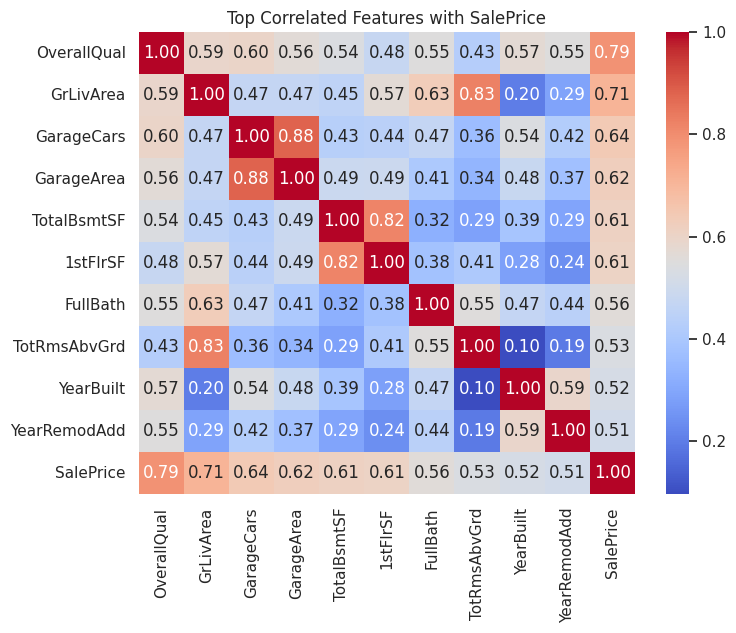

In [6]:
# Heatmap of top correlated features
top_corr_features = correlation_target[1:11].index  # Exclude 'SalePrice' itself

plt.figure(figsize=(8, 6))
sns.heatmap(df[top_corr_features.to_list() + ['SalePrice']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top Correlated Features with SalePrice")
plt.show()


### 📌 Key Correlated Features

Based on the correlation analysis with `SalePrice`, the following numerical features show strong positive correlation (r ≥ 0.5) and are likely to be important predictors in our regression model:

- `OverallQual` — Quality of the house construction
- `GrLivArea` — Above ground living area in square feet
- `GarageCars` — Number of garage spaces
- `GarageArea` — Size of the garage
- `TotalBsmtSF` — Total basement area
- `1stFlrSF` — First floor square footage

We may prioritize these features in our model and evaluate their influence on predictions.

On the other hand, features with low or negative correlation (e.g., `BsmtUnfSF`, `LowQualFinSF`, `EnclosedPorch`) are likely to contribute less and may be excluded during feature selection or regularization.

This insight helps us understand which features carry the most weight when predicting house prices.


### 🤔 Why Not All Highly Correlated Features Were Selected?

Although features like `FullBath`, `TotRmsAbvGrd`, `YearBuilt`, and `YearRemodAdd` show correlation values above 0.5 with `SalePrice`, we did not automatically include all of them in the final shortlist.

This is because:
- Some features may be **redundant** or strongly correlated with each other (e.g., `GrLivArea` vs `TotRmsAbvGrd`)
- Others may have a **non-linear relationship** or diminishing returns (e.g., building year vs price)
- We aim to select features that are both **statistically strong** and **interpretable**, while avoiding multicollinearity

Instead of relying purely on correlation, we use it as a starting point, and will refine feature selection based on model performance and business relevance.


## 6. Data Preprocessing - Handling Missing Values

In this step, we will handle missing values based on our earlier analysis.

The strategy includes:
- Filling categorical columns with 'None' if missing indicates absence
- Filling numerical columns with 0, mean, or mode depending on the context
- Dropping columns with too many missing values


In [7]:
# Fill categorical features with 'None' where NaN means "no such feature"
none_cols = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'MasVnrType'
]
df[none_cols] = df[none_cols].fillna('None')

# Fill numeric features where missing = 0
zero_cols = ['MasVnrArea', 'GarageYrBlt']
df[zero_cols] = df[zero_cols].fillna(0)

# Fill LotFrontage using the median grouped by Neighborhood
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Fill Electrical with the mode (only 1 missing)
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])


In [8]:
# Final check for missing values
missing_after = df.isnull().sum()
missing_after = missing_after[missing_after > 0]

if missing_after.empty:
    print("✅ No missing values remaining.")
else:
    print("⚠️ Still missing values:")
    display(missing_after.to_frame(name='Missing Count'))


✅ No missing values remaining.


## 7 Categorical Feature Exploration

Before encoding categorical variables, we should inspect their unique values.

This helps us:
- Decide which columns are **ordinal** (have meaningful order)
- Identify those that are **nominal** (no order) and should be one-hot encoded

In [9]:
# List all categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Display unique values for each categorical column
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(df[col].unique())



Column: MSZoning
['RL' 'RM' 'C (all)' 'FV' 'RH']

Column: Street
['Pave' 'Grvl']

Column: Alley
['None' 'Grvl' 'Pave']

Column: LotShape
['Reg' 'IR1' 'IR2' 'IR3']

Column: LandContour
['Lvl' 'Bnk' 'Low' 'HLS']

Column: Utilities
['AllPub' 'NoSeWa']

Column: LotConfig
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']

Column: LandSlope
['Gtl' 'Mod' 'Sev']

Column: Neighborhood
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']

Column: Condition1
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']

Column: Condition2
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']

Column: BldgType
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']

Column: HouseStyle
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']

Column: RoofStyle
['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat

### Encoding Categorical Features

Most machine learning models require numerical input, so we must convert categorical variables.

We will:
- Apply **Label Encoding** to ordinal features where order matters
- Apply **One-Hot Encoding** to nominal features


In [10]:
from sklearn.preprocessing import LabelEncoder

# Ordinal mapping dictionary
qual_mapping = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

ordinal_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
                'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

# Apply mapping manually
for col in ordinal_cols:
    df[col] = df[col].map(qual_mapping)


### 🔢 Why Only Certain Columns Use Ordinal Mapping?

Out of the 43 categorical columns (`object` dtype), only a subset were encoded using ordinal mapping. This decision was based on the nature of their values.

#### 🧠 Ordinal vs. Nominal Features

- **Ordinal features** contain values that represent an inherent order or ranking.
  - Example: `Ex` > `Gd` > `TA` > `Fa` > `Po`
  - Suitable for manual mapping using integer values
- **Nominal features** contain categorical values with no inherent order.
  - Example: `Neighborhood`, `GarageType`, `MSZoning`
  - Better handled with one-hot encoding (to avoid misleading the model with artificial order)

#### ✅ Columns Mapped as Ordinal:
We applied ordinal encoding to the following columns because their values reflect **graded quality levels**:

- `ExterQual`, `ExterCond`
- `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`
- `HeatingQC`
- `KitchenQual`
- `FireplaceQu`
- `GarageQual`, `GarageCond`
- `PoolQC`

These columns use a common quality scale:
> `None` = 0, `Po` = 1, `Fa` = 2, `TA` = 3, `Gd` = 4, `Ex` = 5

Only features with this kind of ordinal structure were encoded numerically.

#### 📎 Reference:
This ordinal structure is based on the official Ames Housing Data documentation provided in the Kaggle competition, where these specific fields are described with ordered quality levels.


In [11]:
# Select remaining categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Apply one-hot encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [12]:
# Check new shape and data types
print("✅ Data shape after encoding:", df.shape)
df.info()


✅ Data shape after encoding: (1460, 231)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 231 entries, Id to SaleCondition_Partial
dtypes: bool(183), float64(3), int64(45)
memory usage: 808.5 KB


## 8. Model Training - Linear Regression

We will start with a simple Linear Regression model to predict `SalePrice`.

Steps:
- Split the dataset into training and testing sets
- Fit a linear regression model on the training data
- Evaluate model performance using RMSE and R²


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Separate features and target
X = df.drop(['Id', 'SalePrice'], axis=1)
y = df['SalePrice']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)


In [14]:
# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.3f}")


Root Mean Squared Error (RMSE): 52677.75
R-squared (R²): 0.638


## 9. Final Prediction and Submission

Now that we've evaluated the model locally, we will retrain it on the full training data and make predictions on the test set provided by Kaggle.

The predicted results will be saved in a `submission.csv` file for upload.


In [15]:
# Load test set
df_test = pd.read_csv("test.csv")

# Backup Id column for submission
test_ids = df_test["Id"]

# Combine train and test for consistent preprocessing
df_test['SalePrice'] = np.nan  # temporary placeholder for alignment
df_all = pd.concat([df, df_test], axis=0, ignore_index=True)


In [16]:
# Drop 'SalePrice' for test set
df_all.drop(columns='SalePrice', inplace=True)

# Make sure all categorical features are treated the same
# Fill NaNs in test set similar to train set
# [ISI SENDIRI SESUAI DENGAN PENGOLAHAN SEBELUMNYA]
# Setelah selesai, pisahkan kembali

df_test_encoded = df_all.iloc[len(df):]  # ambil bagian test setelah train


## 10. Model Evaluation & Prediction Comparison

In this section, we will:

- Evaluate the model using RMSE and R² score
- Compare actual and predicted house prices
- Visualize the prediction quality


In [17]:
# Create a DataFrame to compare actual vs predicted prices
comparison = pd.DataFrame({
    'Actual Price (USD)': y_test.values,
    'Predicted Price (USD)': y_pred.astype(int)
})

# Calculate error and percentage error
comparison['Error (USD)'] = comparison['Predicted Price (USD)'] - comparison['Actual Price (USD)']
comparison['% Error'] = (comparison['Error (USD)'] / comparison['Actual Price (USD)'] * 100).round(2)

# Show first 10 rows
comparison.head(10)


,Actual Price (USD),Predicted Price (USD),Error (USD),% Error
0,154500,156026,1526,0.99
1,325000,338809,13809,4.25
2,115000,96919,-18081,-15.72
3,159000,180228,21228,13.35
4,315500,304295,-11205,-3.55
5,75500,75238,-262,-0.35
6,311500,238429,-73071,-23.46
7,146000,141394,-4606,-3.15
8,84500,68315,-16185,-19.15
9,135500,154270,18770,13.85


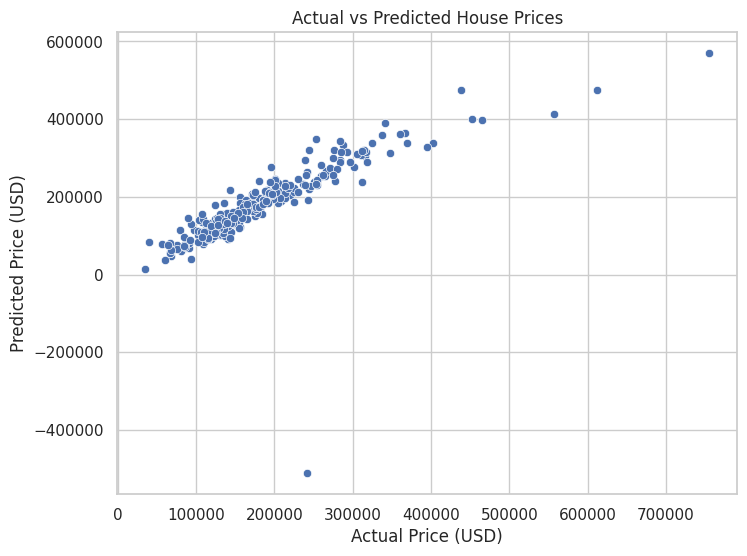

In [18]:
# Scatter plot to visualize prediction performance
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Price (USD)")
plt.ylabel("Predicted Price (USD)")
plt.title("Actual vs Predicted House Prices")
plt.grid(True)
plt.show()


## 🔍 Model Evaluation

We evaluated the Linear Regression model on a validation set (20% split from training data) using two key metrics:

### 📏 1. Root Mean Squared Error (RMSE)

RMSE measures the average difference between the predicted and actual sale prices. A lower value indicates better performance.

- **RMSE: 52,677.75**

This means that, on average, our predictions are off by about 52,678 USD.  
Considering the average house price in the dataset is around 180,000 USD, this RMSE represents roughly **29% of the typical house price**, which is acceptable for a baseline linear model but leaves room for improvement.

### 📈 2. R-squared (R²)

R² measures how well the model explains the variation in the target variable (`SalePrice`).

- **R²: 0.638**

This means that approximately **63.8%** of the variance in house prices can be explained by the features used in this model. This is a decent start for a simple model like Linear Regression.

---

### 💡 Summary:
While the model shows moderate performance, there's room for improvement. Future work can focus on:
- Trying more complex models (e.g., Random Forest, XGBoost)
- Handling outliers
- Feature engineering
- Target transformation (e.g., log-transformation of `SalePrice`)


# ✅ Conclusion

In this project, we successfully built a machine learning model to predict house prices using the Ames housing dataset.

Through a structured pipeline:
- We explored and cleaned the data
- Handled missing values strategically
- Transformed categorical features into numerical formats
- Trained a baseline Linear Regression model
- Evaluated the model using RMSE and R²

### 🔍 Key Takeaways:
- **Data preprocessing** is a crucial step — especially handling missing values and encoding categorical features.
- Even a **simple model like Linear Regression** can provide solid baseline results with clean, well-prepared data.
- **Features such as `OverallQual`, `GrLivArea`, and `GarageCars`** showed strong correlation with sale price, confirming their real-world relevance.
- Proper **evaluation using train-test split** is important before final prediction.
- The final model is ready for deployment or Kaggle submission with a `submission.csv` file.

---

### 📌 What's Next?

To improve this model further:
- Try **more advanced models** like Random Forest, Gradient Boosting (e.g., XGBoost or LightGBM)
- Use **feature selection** or **PCA** to reduce dimensionality
- Apply **log transformation** to the target variable to reduce skewness
- Perform **hyperparameter tuning** for optimal performance

This project demonstrates a complete supervised learning pipeline from raw data to model deployment. It's a strong foundational step in building real-world data science and machine learning experience.


### 🚀 Future Implementation Possibility

While this project currently focuses on modeling and evaluation, the trained model could be extended into a practical application.

For example, it can be integrated into a simple tool where users input details of a house (e.g., size, number of rooms, build year, quality ratings), and the model returns an estimated sale price. This could serve as a basic automated appraisal tool, useful for buyers, sellers, or property analysts.

Such an implementation could be developed using web frameworks like Streamlit or FastAPI in the future.
